In [8]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [9]:
def fetch_earthquake_data(datemin='2025-09-10', datemax='2025-10-11', latmax=46,
                        lonmin=123, lonmax=146, latmin=24, magmin=1, fmt='html', nmax=1000):
    """
    Fetch earthquake data from GEOFON for Japan region.
    """
    base_url = 'https://geofon.gfz.de/eqinfo/list.php'
    
    params = {
        'datemin': datemin,
        'datemax': datemax,
        'latmax': latmax,
        'lonmin': lonmin,
        'lonmax': lonmax,
        'latmin': latmin,
        'magmin': magmin,
        'fmt': fmt,
        'nmax': nmax
    }
    
    print(f"Fetching data from {base_url}...")
    response = requests.get(base_url, params=params)
    response.raise_for_status()  # Raise an error for bad status codes
    soup = BeautifulSoup(response.content, 'html.parser')
    
    # Find the earthquake list container
    eqlist = soup.find('div', {'id': 'eqlist'})
    if not eqlist:
        print("No earthquake data found in the response")
        return pd.DataFrame()
    
    earthquakes = []
    
    # Each earthquake is in a div with class "flex-row row eqinfo-all"
    # Find even and odd rows separately
    evn_event_rows = soup.find_all('div', class_='flex-row row eqinfo-all evnrow')
    odd_event_rows = soup.find_all('div', class_='flex-row row eqinfo-all oddrow')
    
    # Create alternating sequence: first from even, then odd, then even, etc.
    event_rows = []
    max_length = max(len(evn_event_rows), len(odd_event_rows))
    
    for i in range(max_length):
        if i < len(evn_event_rows):
            event_rows.append(evn_event_rows[i])
        if i < len(odd_event_rows):
            event_rows.append(odd_event_rows[i])
    
    for row in event_rows:
        try:
            # Extract magnitude from the magbox span
            mag_span = row.find('span', class_='magbox')
            if not mag_span:
                continue
            magnitude = float(mag_span.get_text(strip=True))
            
            # Extract region from the strong tag
            region_strong = row.find('strong')
            if not region_strong:
                continue
            region = region_strong.get_text(strip=True)
            
            # Extract coordinates from the title attribute
            region_div = row.find('div', title=True)
            coordinates = region_div.get('title', '') if region_div else ''
            
            latitude = None
            longitude = None
            if coordinates:
                try:
                    # Split by comma
                    parts = coordinates.split(', ')
                    if len(parts) == 2:
                        lon_part = parts[0].replace('°E', '').replace('°W', '')
                        lat_part = parts[1].replace('°N', '').replace('°S', '')
                        longitude = float(lon_part)
                        latitude = float(lat_part)
                except (ValueError, IndexError):
                    pass
            
            # Extract time and depth from the second row
            time_depth_row = row.find_all('div', class_='row')[1]
            time_depth_text = time_depth_row.get_text(strip=True)
            
            # Parse time and depth
            # checking the format: "2025-10-11 14:24:22.4 (≤2 h ago) 86*"
            time_text = ""
            depth_text = ""
            
            # Split by the pull-right span to separate time and depth
            time_span = time_depth_row.find('span', class_='pull-right')
            if time_span:
                # Remove the pull-right span to get time
                time_span.extract()
                time_text = time_depth_row.get_text(strip=True)
                # Clean up time text (remove relative time info)
                time_text = str(time_text.split('(')[0].strip().split('.')[0].strip())
                depth_text = str(time_span.get_text(strip=True).replace('*', '').strip())
            else:
                # Fallback: try to extract from the full text
                time_text = str(time_depth_text.split('(')[0].strip().split('.')[0].strip())
                
                import re
                depth_match = re.search(r'(\d+)\*?$', time_depth_text)
                if depth_match:
                    depth_text = str(depth_match.group(1))
            
            # Extract event ID from the parent link
            parent_link = row.find_parent('a')
            event_id = ""
            if parent_link and parent_link.get('href'):
                href = parent_link.get('href')
                # Extract ID from URL like "event.php?id=gfz2025tydw"
                if 'id=' in href:
                    event_id = href.split('id=')[1]
            
            earthquakes.append({
                'Magnitude': magnitude,
                'Region': region,
                'DateTime_UTC': time_text,
                'Depth_km': depth_text if depth_text else None,
                'Latitude': latitude,
                'Longitude': longitude,
                'Event_ID': event_id
            })
            
        except (ValueError, AttributeError, IndexError) as e:
            print(f"Error parsing earthquake data: {e}")
            continue
    
    df = pd.DataFrame(earthquakes)
    
    print(f"Successfully fetched {len(df)} earthquake records")
    return df

In [10]:
# you can use this function with different parameters to get different data
# df = fetch_earthquake_data(
#     datemin='2024-03-02',
#     datemax='2025-10-11',
#     magmin=5.0 , # Only earthquakes with magnitude 5.0 or higher
#     nmax=500
# )
# you can use this function to get all the data based on the default parameters
df = fetch_earthquake_data(datemin='2025-01-01')
print("\nEarthquake Data:")
df.tail(10)


Fetching data from https://geofon.gfz.de/eqinfo/list.php...
Successfully fetched 323 earthquake records

Earthquake Data:


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID
313,4.8,"Bonin Islands, Japan Region",2025-01-12 17:58:33,417,28.13,140.08,gfz2025avmc
314,5.0,"Kyushu, Japan",2025-01-13 16:14:58,46,32.08,131.73,gfz2025axef
315,5.3,"Volcano Islands, Japan Region",2025-01-07 17:23:49,546,24.34,142.11,gfz2025amhl
316,5.1,"Bonin Islands, Japan Region",2025-01-12 22:21:16,59,28.22,142.42,gfz2025avuu
317,4.7,"Hokkaido, Japan Region",2025-01-07 02:47:22,160,41.24,140.34,gfz2025aleo
318,4.8,"Kyushu, Japan",2025-01-08 14:40:29,10,30.10,131.07,gfz2025anxo
319,4.6,"Shikoku, Japan",2025-01-06 09:22:50,42,32.47,132.05,gfz2025ajwb
320,5.2,"Off East Coast of Honshu, Japan",2025-01-06 16:44:39,10,35.76,142.24,gfz2025akkr
321,4.8,"Off East Coast of Honshu, Japan",2025-01-03 04:20:43,10,33.45,142.14,gfz2025adzp
322,5.0,"Off East Coast of Honshu, Japan",2025-01-05 13:35:00,10,33.44,142.03,gfz2025aiix


In [11]:
# Save data to CSV file
df.to_csv('JAPAN_GEOFON.csv', index=False, encoding='utf-8')
print("Data saved to 'JAPAN_GEOFON.csv'")

Data saved to 'JAPAN_GEOFON.csv'


# Working On Data With Pandas Library

In [12]:
import pandas as pd

csv_path = 'JAPAN_GEOFON.csv'
df_csv = pd.read_csv(csv_path)
print('Loaded CSV:', csv_path)
print('Shape (rows, cols):', df_csv.shape)
df_csv.head()


Loaded CSV: JAPAN_GEOFON.csv
Shape (rows, cols): (323, 7)


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID
0,4.8,"Ryukyu Islands, Japan",2025-10-11 14:24:22,86,27.17,127.70,gfz2025tydw
1,4.8,"Southeast of Honshu, Japan",2025-10-11 03:22:02,445,30.39,138.44,gfz2025txia
2,5.3,"Ryukyu Islands, Japan",2025-10-07 21:38:38,10,29.34,129.10,gfz2025trkf
3,4.8,"Off East Coast of Honshu, Japan",2025-10-07 01:17:17,10,37.77,144.19,gfz2025tpvx
4,5.1,"Near East Coast of Honshu, Japan",2025-10-07 00:30:25,53,37.58,141.27,gfz2025tpuj


In [13]:
# split Time from date, Conver to numeric floats
import numpy as np

# expected_cols = ['DateTime_UTC', 'Magnitude', 'Depth_km', 'Latitude', 'Longitude', 'Region']
# missing_cols = [c for c in expected_cols if c not in df_csv.columns]
# if missing_cols:
#     print('Warning - missing columns in CSV:', missing_cols)


# Parse to datetime (coerce errors to NaT)
df_csv['DateTime_UTC'] = pd.to_datetime(df_csv['DateTime_UTC'], errors='coerce', utc=True)

# Create Time column (HH:MM:SS) in UTC
Time = df_csv['DateTime_UTC'].dt.strftime('%H:%M:%S')
df_csv['Time'] = Time

# Keep only the date part in DateTime_UTC
df_csv['DateTime_UTC'] = df_csv['DateTime_UTC'].dt.floor('D')

# Convert numeric to floats
for col in ['Magnitude', 'Depth_km', 'Latitude', 'Longitude']:
    df_csv[col] = pd.to_numeric(df_csv[col], errors='coerce')

print('Dtypes after conversion:')
print(df_csv.dtypes)
df_csv.head()


Dtypes after conversion:
Magnitude                   float64
Region                       object
DateTime_UTC    datetime64[ns, UTC]
Depth_km                      int64
Latitude                    float64
Longitude                   float64
Event_ID                     object
Time                         object
dtype: object


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID,Time
0,4.8,"Ryukyu Islands, Japan",2025-10-11 00:00:00+00:00,86,27.17,127.70,gfz2025tydw,14:24:22
1,4.8,"Southeast of Honshu, Japan",2025-10-11 00:00:00+00:00,445,30.39,138.44,gfz2025txia,03:22:02
2,5.3,"Ryukyu Islands, Japan",2025-10-07 00:00:00+00:00,10,29.34,129.10,gfz2025trkf,21:38:38
3,4.8,"Off East Coast of Honshu, Japan",2025-10-07 00:00:00+00:00,10,37.77,144.19,gfz2025tpvx,01:17:17
4,5.1,"Near East Coast of Honshu, Japan",2025-10-07 00:00:00+00:00,53,37.58,141.27,gfz2025tpuj,00:30:25


In [14]:
# Handling missing values

before_na_counts = df_csv.isna().sum()
before_rows = len(df_csv)
print('Missing values before handling:')
print(before_na_counts)

# Drop rows with critical missing data
critical_cols = ['DateTime_UTC', 'Magnitude', 'Region']
df_clean = df_csv.dropna(subset=critical_cols).copy()

# new strategy to fill the missing values
if df_clean['Depth_km'].isna().any():
    median_depth = df_clean['Depth_km'].median()
    df_clean['Depth_km'] = df_clean['Depth_km'].fillna(median_depth)


after_na_counts = df_clean.isna().sum()
after_rows = len(df_clean)
print('\nRows before:', before_rows, 'Rows after:', after_rows)
print('Dropped rows:', before_rows - after_rows)
print('\nMissing values after handling:')
print(after_na_counts)

# Use cleaned df for further analysis
df_work = df_clean
print('\nData types now:')
print(df_work.dtypes)


Missing values before handling:
Magnitude       0
Region          0
DateTime_UTC    0
Depth_km        0
Latitude        0
Longitude       0
Event_ID        0
Time            0
dtype: int64

Rows before: 323 Rows after: 323
Dropped rows: 0

Missing values after handling:
Magnitude       0
Region          0
DateTime_UTC    0
Depth_km        0
Latitude        0
Longitude       0
Event_ID        0
Time            0
dtype: int64

Data types now:
Magnitude                   float64
Region                       object
DateTime_UTC    datetime64[ns, UTC]
Depth_km                      int64
Latitude                    float64
Longitude                   float64
Event_ID                     object
Time                         object
dtype: object


In [15]:
# Create Month column

df_work['Month'] = df_work['DateTime_UTC'].dt.to_period('M').astype(str)
print('Added Month column. Unique months:', sorted(df_work['Month'].unique()))
# df_work[['DateTime_UTC','Time','Month']].head()
df_work.head()

Added Month column. Unique months: ['2025-01', '2025-02', '2025-03', '2025-04', '2025-05', '2025-06', '2025-07', '2025-08', '2025-09', '2025-10']


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5736\3771976870.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df_work['Month'] = df_work['DateTime_UTC'].dt.to_period('M').astype(str)


,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID,Time,Month
0,4.8,"Ryukyu Islands, Japan",2025-10-11 00:00:00+00:00,86,27.17,127.70,gfz2025tydw,14:24:22,2025-10
1,4.8,"Southeast of Honshu, Japan",2025-10-11 00:00:00+00:00,445,30.39,138.44,gfz2025txia,03:22:02,2025-10
2,5.3,"Ryukyu Islands, Japan",2025-10-07 00:00:00+00:00,10,29.34,129.10,gfz2025trkf,21:38:38,2025-10
3,4.8,"Off East Coast of Honshu, Japan",2025-10-07 00:00:00+00:00,10,37.77,144.19,gfz2025tpvx,01:17:17,2025-10
4,5.1,"Near East Coast of Honshu, Japan",2025-10-07 00:00:00+00:00,53,37.58,141.27,gfz2025tpuj,00:30:25,2025-10


In [16]:
# Create Category column

bins = [-np.inf, 4, 6, np.inf]
labels = ['Weak', 'Moderate', 'Strong']
df_work['Category'] = pd.cut(df_work['Magnitude'], bins=bins, labels=labels, right=False)
print('Category value counts:')
print(df_work['Category'].value_counts(dropna=False))
df_work[['Magnitude','Category']].head()


Category value counts:
Category
Moderate    323
Weak          0
Strong        0
Name: count, dtype: int64


,Magnitude,Category
0,4.8,Moderate
1,4.8,Moderate
2,5.3,Moderate
3,4.8,Moderate
4,5.1,Moderate


In [17]:
# Group by Month and Category, calculate mean and count

agg_month_cat = (df_work
                 .groupby(['Month','Category'])
                 .agg(mean_magnitude=('Magnitude','mean'),
                      mean_depth_km=('Depth_km','mean'),
                      count=('Magnitude','count'))
                 .reset_index())
print('Aggregated by Month and Category:')
agg_month_cat


Aggregated by Month and Category:


C:\Users\Administrator\AppData\Local\Temp\ipykernel_5736\3743031519.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Month','Category'])


,Month,Category,mean_magnitude,mean_depth_km,count
0,2025-01,Weak,NaN,NaN,0
1,2025-01,Moderate,4.788235,96.470588,34
2,2025-01,Strong,NaN,NaN,0
3,2025-02,Weak,NaN,NaN,0
4,2025-02,Moderate,4.890909,112.545455,22
5,2025-02,Strong,NaN,NaN,0
6,2025-03,Weak,NaN,NaN,0
7,2025-03,Moderate,4.706667,110.600000,30
8,2025-03,Strong,NaN,NaN,0
9,2025-04,Weak,NaN,NaN,0


In [18]:
# Extract name_area from Region - first part before comma. I dont get how to handle region regarding the question 

df_work['name_area'] = df_work['Region'].astype(str).str.split(',').str[0].str.strip()
print('Extracted name_area. Sample:')
df_work[['Region','name_area']].head()

Extracted name_area. Sample:


,Region,name_area
0,"Ryukyu Islands, Japan",Ryukyu Islands
1,"Southeast of Honshu, Japan",Southeast of Honshu
2,"Ryukyu Islands, Japan",Ryukyu Islands
3,"Off East Coast of Honshu, Japan",Off East Coast of Honshu
4,"Near East Coast of Honshu, Japan",Near East Coast of Honshu


In [46]:
df_work.head()

,Magnitude,Region,DateTime_UTC,Depth_km,Latitude,Longitude,Event_ID,Time,Month,Category,name_area
0,4.8,"Ryukyu Islands, Japan",2025-10-11 00:00:00+00:00,86,27.17,127.70,gfz2025tydw,14:24:22,2025-10,Moderate,Ryukyu Islands
1,4.8,"Southeast of Honshu, Japan",2025-10-11 00:00:00+00:00,445,30.39,138.44,gfz2025txia,03:22:02,2025-10,Moderate,Southeast of Honshu
2,5.3,"Ryukyu Islands, Japan",2025-10-07 00:00:00+00:00,10,29.34,129.10,gfz2025trkf,21:38:38,2025-10,Moderate,Ryukyu Islands
3,4.8,"Off East Coast of Honshu, Japan",2025-10-07 00:00:00+00:00,10,37.77,144.19,gfz2025tpvx,01:17:17,2025-10,Moderate,Off East Coast of Honshu
4,5.1,"Near East Coast of Honshu, Japan",2025-10-07 00:00:00+00:00,53,37.58,141.27,gfz2025tpuj,00:30:25,2025-10,Moderate,Near East Coast of Honshu


In [19]:
# Group by area: count, mean, max

area_stats = (df_work
              .groupby('name_area')
              .agg(
                  num_quakes=('Event_ID','count'),
                  mean_magnitude=('Magnitude','mean'),
                  mean_depth_km=('Depth_km','mean'),
                  max_magnitude=('Magnitude','max'),
                  max_depth_km=('Depth_km','max')
              )
              .sort_values('num_quakes', ascending=False)
             )
print('Area-level statistics:')
area_stats.head(20)

Area-level statistics:


,num_quakes,mean_magnitude,mean_depth_km,max_magnitude,max_depth_km
name_area,,,,,
Ryukyu Islands,93,4.882796,21.075269,5.5,134
Hokkaido,48,4.820833,71.562500,5.4,324
Near East Coast of Honshu,44,4.793182,51.704545,5.2,103
Southeast of Honshu,31,4.683871,209.258065,5.5,451
Off East Coast of Honshu,24,4.795833,11.750000,5.2,37
Kyushu,16,4.837500,46.625000,5.5,167
Bonin Islands,15,4.580000,388.466667,5.1,515
Eastern Honshu,11,4.772727,63.636364,5.1,156
Southwestern Ryukyu Islands,10,4.800000,58.000000,5.4,121


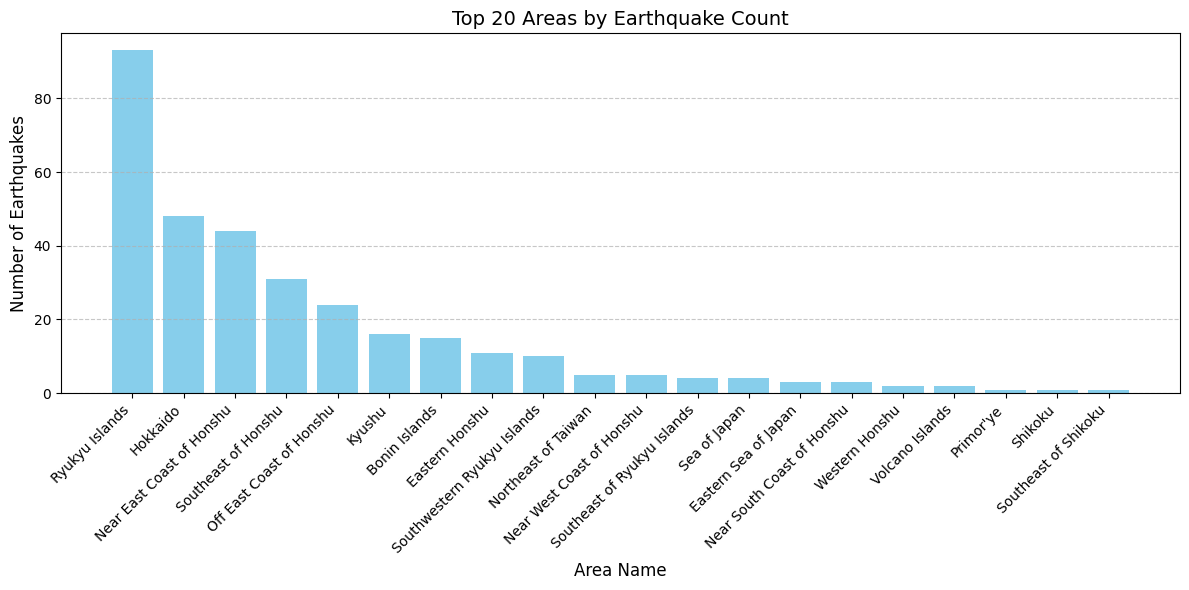

In [20]:
import matplotlib.pyplot as plt

# just Select the top 20 areas for plotting
top_20_areas = area_stats.head(20)
plt.figure(figsize=(12, 6))
plt.bar(top_20_areas.index, top_20_areas['num_quakes'], color='skyblue')
plt.xlabel('Area Name', fontsize=12)
plt.ylabel('Number of Earthquakes', fontsize=12)
plt.title('Top 20 Areas by Earthquake Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('earthquake_counts_by_area_barchart.png')
# plt.close() 

In [49]:
# print(f"\nTotal earthquakes: {len(df)}")
# print(f"\nMagnitude range: {df['Magnitude'].min()} - {df['Magnitude'].max()}")
# print(f"\nRegion distribution:")
# print(df['Region'].value_counts())
# print(f"\nDataFrame Info:")
# print(df.info())
# print(f"\nSample data with all columns:")
# # print(df.head())
# df.head()
